In [1]:
%load_ext autoreload
%autoreload
from pathlib import Path
import numpy as np
import pandas as pd
from datetime import datetime
import importlib
import fluxlib
importlib.reload(fluxlib)
from fluxlib import *
from scitbx import *

In [6]:
## Formatting flux data

cfg_path = r"C:\workspace\repositories\fluxlib\fluxlib\preprocessing\config.yaml"
# Can use ERA5 parameters
formatter = Formatter(cfg_path)
# save formatted df into csv and mds txt
formatter()

griffin


In [8]:
## Borrow aux from other sites

# Roth LiCOR
lender_path = r"C:\workspace\fmt_roth\Red_EddyPro_2017-2018_fmt.csv"
flux = "NEE"
scale = "15T"
# Roth Lowcost
loader = Loader(r"C:\workspace\fmt_roth_lowcost\Roth_N_fmt.csv")
df = loader()
df = borrow(df, lender_path, "NEE",scale = scale)
# print(df)

In [ ]:
# fill drivers
loader = Loader(r"C:\workspace\fmt_griffin\griffin_fmt.csv")
drivers = ["VPD", "Rg", "Tair"]
df = loader()
df_new = find_start(df, drivers = drivers)
for driver in drivers:
    filler = AuxFiller(df_new[[driver]])
    filled = filler()
    print(filled)
    df_new[driver] = filled[driver]
df_new.to_csv(r"C:\workspace\fmt_griffin\griffin_fmt_aux_filled.csv")

In [10]:
# Make artificial gaps

%autoreload
loader = Loader(r"C:\workspace\fmt_griffin\griffin_fmt_aux_filled.csv")
drivers = ["VPD", "Rg", "Tair"]
flux = ["NEE"]
df = loader()

# make gaps
config_path = r"C:\workspace\repositories\fluxlib\fluxlib\gapfill\make_gaps_cfg.yaml"

train_idx, test_idx = utils.make_gap_pipeline(config_path, df, "NEE")

# print(len(train_idx))
# print(len(test_idx))
# print(df.__len__())

# print(df[["NEE"]].iloc[test_idx])

In [11]:
# Filling gaps

# %load_ext autoreload
%autoreload

df_orig = df.copy()
# ===========================================================================
cfg_path = r"C:\workspace\repositories\fluxlib\fluxlib\gapfill\ggapfill.yaml"
filler = GFiller(cfg_path)

print("===============================================================")
res, app = filler.run_filling_pipeline(df, itrain = train_idx, itest = test_idx)
print("===============================================================")
# print(res)

filler.save_mds_txt(df, test_idx, r"C:\workspace\fmt_griffin", "griffin")
# df.iloc[test_idx, :]
df_orig["NEE"] = app["estimates"]

df_orig.to_csv(r"C:\workspace\fmt_griffin\griffin_filled.csv")

using input train & test
test_site, 0.6693, 3.9494


In [12]:
# partitioning
loader = Loader(r"C:\workspace\fmt_griffin\griffin_filled.csv")
drivers = ["VPD", "Rg", "Tair"]
flux = ["NEE"]

df = loader()

GPP, Reco = neepart_wrapper(nee2gpp, df, method = "global")

print(GPP)
print(Reco)

[ 0.39600708 -0.05227558  0.03859189 ...  0.57024802  0.57745428
  0.7015265 ]
[0.51959058 0.35654076 0.34411587 ... 0.74546853 0.74659298 0.74539359]


[ 0.39600708 -0.05227558  0.03859189 ...  0.57024802  0.57745428
  0.7015265 ]
[0.51959058 0.35654076 0.34411587 ... 0.74546853 0.74659298 0.74539359]


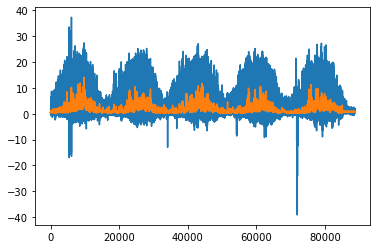

In [1]:
# # DRAFT

# %reload_ext autoreload
# %autoreload
# from fluxlib import *
# from matplotlib import pyplot as plt
# import numpy as np

# def neepart_wrapper(func_part, df, undef = -9999, method = "global"):
#     df["Tair"] += 273.15
#     df["VPD"] *= 100
#     df = df.rename(
#         columns = {
#             'NEE': 'FC', 'Rg': 'SW_IN', 'Tair': 'TA', 'VPD': 'VPD'
#         }
#     )
#     df = df.loc[:, ['FC', 'SW_IN', 'TA', 'VPD']]
#     df = df.replace(np.nan, undef)
#     dates = df.index
#     df = df.values.T
#     flag = np.where(df == undef, 2, 0)
#     colhead = ['FC', 'SW_IN', 'TA', 'VPD']
#     GPP, Reco = func_part(df, flag = flag, date = dates, colhead = colhead, undef = undef, method = method)
#     return GPP, Reco


# # partitioning
# loader = Loader(r"C:\workspace\fmt_griffin\griffin_filled.csv")
# drivers = ["VPD", "Rg", "Tair"]
# flux = ["NEE"]

# df = loader()

# GPP, Reco = neepart_wrapper(nee2gpp, df, method = "global")
# plt.plot(GPP)
# plt.plot(Reco)
# print(GPP)
# print(Reco)
# plt.show()
    

# # # undef = -9999
# # # df = df.replace(np.nan, undef)
# # # adate = df.index
# # # df = df.rename(
# # #     columns = {
# # #         'NEE': 'FC', 'Rg': 'SW_IN', 'Tair': 'TA', 'VPD': 'VPD'
# # #     }
# # # )
# # # # print(df)
# # # df = df.loc[:, ['FC', 'SW_IN', 'TA', 'VPD']]
# # # # print(flag.shape)
# # # print(df.values.T.shape)
# # # flag = np.where(df.values.T == undef, 2, 0)
# # # print(flag.shape)
# # # colhead = df.columns.tolist()
# # # GPP, Reco = nee2gpp(df.values.T, flag=flag, date=adate, colhead=colhead, undef=undef, method='global')

# # # print(GPP.shape)
# # # print(Reco.shape)

# # # # parter = Partitioner(df)

# # import numpy as np
# # from hesseflux.fread import fread
# # from hesseflux.date2dec import date2dec
# # from hesseflux.dec2date import dec2date
# # from hesseflux import nee2gpp
# # ifile = r'C:\Users\sz394\Downloads\hesseflux-master\hesseflux\test_nee2gpp.csv'
# # undef = -9999.
# # dat   = fread(ifile, skip=2, transpose=True)
# # ndat  = dat.shape[1]
# # head  = fread(ifile, skip=2, header=True)
# # print(f"head: {head}")
# # head1 = head[0]
# # print(f"head1: {head1}")
# # # date
# # jdate = date2dec(dy=dat[0,:], mo=dat[1,:], yr=dat[2,:], hr=dat[3,:], mi=dat[4,:])
# # print(f"jdate: {jdate}")
# # adate = dec2date(jdate, eng=True)
# # print(f"adate: {adate}")
# # # colhead
# # idx   = []
# # for i in head1:
# #     if i in ['NEE', 'rg', 'Tair', 'VPD']: idx.append(head1.index(i))
# # colhead = ['FC', 'SW_IN', 'TA', 'VPD']
# # print(f"idx: {idx}")
# # # data
# # dfin = dat[idx,:]
# # print(f"dfin1: {dfin}")
# # dfin[2,:] = np.where(dfin[2,:] == undef, undef, dfin[2,:]+273.15)
# # dfin[3,:] = np.where(dfin[3,:] == undef, undef, dfin[3,:]*100.)
# # print(f"dfin2: {dfin}")
# # # flag
# # flag = np.where(dfin == undef, 2, 0)
# # print(f"flag: {flag.shape}")
# # print(np.where(dfin == undef))
# # # partition
# # print(dfin.shape)
# # GPP, Reco = nee2gpp(dfin, flag=flag, date=adate, colhead=colhead, undef=undef, method='global')
# # # print(GPP[1120:1128])
# # print(GPP)
# # print(Reco)